# 0.0 IMPORTS

In [1]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import seaborn                  as sns
import plotly.express           as px
import scikitplot               as skplt
import xgboost                  as xgb
import random
import warnings

from matplotlib                 import gridspec

from plotly.subplots            import make_subplots
from plotly                     import graph_objects as go

from IPython.core.display       import HTML
from IPython.display            import Image

from scipy.interpolate          import interp1d
from scipy                      import stats as ss


from imblearn.pipeline          import Pipeline
from imblearn.under_sampling    import TomekLinks
from imblearn.over_sampling     import SMOTE
from imblearn.combine           import SMOTETomek



from sklearn                    import model_selection as ms
from sklearn                    import preprocessing as pp
from sklearn                    import linear_model as lm
from sklearn.compose            import ColumnTransformer
from sklearn                    import ensemble as en
from sklearn                    import neighbors
from sklearn                    import svm
from sklearn.naive_bayes        import GaussianNB
from sklearn.metrics            import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, auc, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.neighbors          import KNeighborsClassifier


from skopt                      import BayesSearchCV
from lightgbm                   import LGBMClassifier
from catboost                   import CatBoostClassifier

## 0.1 Helper Functions

In [2]:
def show_percentage(ax, df):
    for p in ax.patches:
        height = p.get_height()
        # Adicionar rótulo de porcentagem somente se a altura da barra for maior que 0
        if height > 0:
            ax.text(p.get_x() + p.get_width() / 2., 
                    height + 0.05, 
                    '{:.2f}%'.format(height * 100 / len(df)), 
                    ha="center")


def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None

    sns.set()

def precision_at_k(data, k = 1000):
    data = data.reset_index(drop=True)

    data['ranking'] = data.index +1

    data['precision_at_k'] = data['Exited'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, k = 1000):
    data = data.reset_index(drop=True)

    data['ranking'] = data.index +1

    data['recall_at_k'] = data['Exited'].cumsum() / data['Exited'].sum()

    return data.loc[k, 'recall_at_k']



def precision_recall_at_k(model_name, x_val, y_val, y_prob, top_k = 1000):
    df8 = x_val.copy()
    df8['Exited'] = y_val.copy()

    df8['score'] = y_prob[:,1].tolist()

    # Sort by propensity score
    df8 = df8.sort_values(by='score', ascending=False).reset_index(drop=True)

    # Precision at k
    precision_at_x = round(precision_at_k(data = df8, k = top_k),4)
    recall_at_x = round(recall_at_k(data = df8, k = top_k),4)


    return pd.DataFrame({'Model Name': model_name,
                         'Precision at k': precision_at_x,
                         'Recall at k': recall_at_x}, index=[0])




def cross_validation (model_name, model, x_train, x_val,y_train,y_val, n_splits, top_k = 1000, verbose=False):
    
    if verbose:
        # the lenght_msg is to print only once a specific message
        length_msg = True
        i = 1
    
    # the seed usage provides repeatability 
    np.random.seed(42)
    
    # it is necessary to join the train and validation datasets
    x = pd.concat([x_train,x_val])
    y = pd.concat([y_train,y_val])
    
    
    # definition of the cross-validation strategy
    cv = ms.StratifiedKFold(n_splits = n_splits , random_state= 42, shuffle = True)
    
    precision_at_x = []
    recall_at_x = []
    
    for train_index, val_index in cv.split(x, y):      
        x_train_n , x_val_n = x.iloc[train_index], x.iloc[val_index]
        y_train_n, y_val_n = y.iloc[train_index], y.iloc[val_index]
        
        if (verbose == True) and (length_msg == True):
            print(f'training_lenght:{x_train_n.shape[0]}\nvalidation_lenght:{x_val_n.shape[0]}\n\n')
            length_msg = False
        
        if verbose:
            print(f'Iteration number:{i}')
            i += 1

        # fit and predict_proba
        model.fit(x_train_n, y_train_n)
        yhat_proba = model.predict_proba(x_val_n)

        df_aux = x_val_n.copy()
        df_aux['Exited'] = y_val_n.values
        df_aux['score'] = yhat_proba[:,1].tolist()

        # Sort by propensity score
        df_aux = df_aux.sort_values(by='score', ascending=False).reset_index(drop=True)       
    

        # save the metrics value to the list
        precision_at_x.append(precision_at_k(data = df_aux, k = top_k))
        recall_at_x.append(recall_at_k(data = df_aux, k = top_k))
        

    return pd.DataFrame({ 'Model Name': model_name,
                          'Precision': round(np.mean(precision_at_x), 3).astype(str) + '+/-' + round(np.std(precision_at_x),2).astype(str),
                          'Recall': round(np.mean(recall_at_x), 3).astype(str) + '+/-' + round(np.std(recall_at_x),2).astype(str)}, 
                          index=[0])



def evaluate_classification_model(model_name, y_test, y_pred):
    # Calcular as métricas
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Criar um DataFrame com as métricas
    metrics = {
        'Model':[model_name],
        'Precision': [precision],
        'Recall': [recall],
        'Accuracy': [accuracy],
        'F1 Score': [f1]
    }
    metrics_df = pd.DataFrame(metrics)
    
    return metrics_df

def plot_confusion_matrix(cm, class_names):
    # Criar um DataFrame para a matriz de confusão
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.title('Matriz de Confusão')
    plt.show()

def ranking_score(x_val, y_val, y_hat):
        df_aux = x_val.copy()
        df_aux['response'] = y_val.values
        df_aux['pred'] = (y_prob[:, 1] >= 0.5).astype(int)
        df_aux['score'] = y_hat[:,1].tolist()

        # Sort by propensity score
        df_aux = df_aux.sort_values(by='score', ascending=False).reset_index(drop=True)  
        df_aux_inteiro = df_aux.sort_values(by='score', ascending=False).reset_index(drop=True)       
    
        df_aux['ranking'] = df_aux.index +1
        df_aux['recall_at_k'] = df_aux['response'].cumsum() / df_aux['response'].sum()
        df_aux['precision_at_k'] = df_aux['response'].cumsum() / df_aux['ranking']
    
        percents = np.arange(0.05, 1.05, 0.05)
        k_list = []

        for i in percents:
            k = int(len(df_aux)*i) - 1
            k_list.append( k )

        df_aux = df_aux.loc[k_list, ['score', 'precision_at_k', 'recall_at_k']]
        df_aux['k'] = percents
        df_aux = df_aux[['k', 'precision_at_k', 'recall_at_k', 'score']]
        df_aux = df_aux.reset_index(drop=True)

        return df_aux_inteiro, df_aux

def cramer_v( x, y):
    #confusion matrix
    cm = pd.crosstab(x, y).values
    
    #sum of observations
    n = cm.sum()
    
    #number of lines and columns
    r, k = cm.shape
    
    #chi²
    chi2 = ss.chi2_contingency( cm )[0]
    
    #bias correction
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k-1)**2 / (n - 1)
    rcorr = r - (r-1)**2 / (n - 1)

    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr - 1)))

In [3]:
jupyter_settings()
warnings.filterwarnings('ignore')

## 0.2 Loading Dataset

In [4]:
data_raw = pd.read_csv('./datasets/churn.csv')

X = data_raw.drop(['RowNumber', 'CustomerId', 'Exited', 'Surname'], axis=1)
y = data_raw['Exited']

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
#x_train = x_train[['CreditScore', 'Tenure', 'Gender', 'Age',  'Balance', 'HasCrCard', 'IsActiveMember',  'NumOfProducts',  'EstimatedSalary', 'Geography']].copy()

ssc_cols  = ['Balance', 'CreditScore']
mms_cols = ['NumOfProducts', 'EstimatedSalary', 'Tenure']
rb_cols = ['Age']
ohe_cols = ['Geography', 'Gender']

## 1.0 Making Pipeline

In [6]:
preprocessing = ColumnTransformer(
    transformers=[('min_max_scaler', pp.MinMaxScaler(), mms_cols),
                  ('standard_scaler', pp.StandardScaler(), ssc_cols),
                  ('robust scaler', pp.RobustScaler(), rb_cols),
                  ('onehot_encoder', pp.OneHotEncoder(handle_unknown='ignore'), ohe_cols)
                 ])

lgbm = LGBMClassifier(boosting_type= 'gbdt', colsample_bytree =  1.0, learning_rate =  0.01, max_depth =  5, min_child_samples =  23, n_estimators =  1324, num_leaves =  5, subsample =  0.2,  reg_alpha = 1, reg_lambda = 7, random_state = 42, force_row_wise=True, class_weight='balanced', verbose=-1)
cat = CatBoostClassifier(bagging_temperature = 0.0001, border_count = 175, depth = 8, iterations = 1500, l2_leaf_reg = 30, learning_rate = 0.0046, min_data_in_leaf = 22, random_state=42, scale_pos_weight=1.0, logging_level='Silent')

voting_classifier = en.VotingClassifier(estimators=[('LightGBM Classifier', lgbm), 
                                                    ('CatBoost Classifier', cat)], voting='soft', n_jobs=-1)

pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                           ('balance', TomekLinks()), 
                           ('model', voting_classifier)])

In [7]:
pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)
y_prob = pipeline.predict_proba(x_test)

In [8]:
et_result = precision_recall_at_k('Pipeline_LGBM', x_test, y_test, y_prob, top_k=1000)
display(et_result)

,Model Name,Precision at k,Recall at k
0,Pipeline_LGBM,0.3497,0.8906


In [9]:
cross_val = cross_validation('model Tunned', pipeline, x_train, x_test, y_train, y_test, 5, top_k=1000)
cross_val

,Model Name,Precision,Recall
0,model Tunned,0.362+/-0.01,0.89+/-0.01


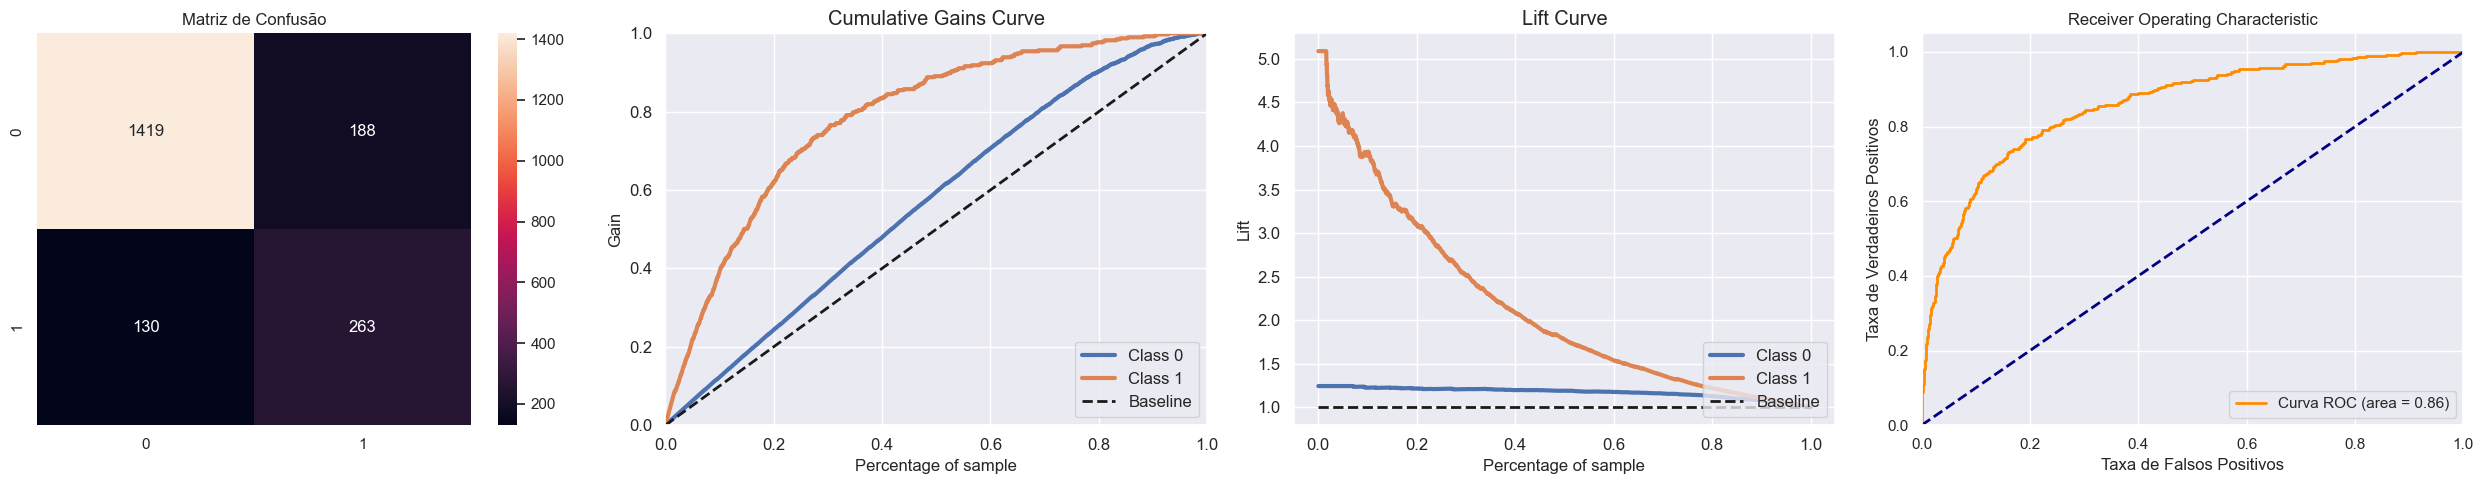

In [10]:
# Nomes das classes
class_names = [str(i) for i in range(len(set(y_test)))]

# Criando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Criando a figura com 5 subplots (1 a mais para a análise da matriz de confusão)
fig, ax = plt.subplots(1, 4, figsize=(25, 5))

# Selecionando o primeiro subplot e plotando a matriz de confusão
ax1 = ax[0]
sns.heatmap(cm,  annot=True,  fmt='d', ax=ax1)
ax1.set_title('Matriz de Confusão')


# Cumulative Gains
skplt.metrics.plot_cumulative_gain(y_test, y_prob, ax=ax[1])


# Lift Curve
skplt.metrics.plot_lift_curve(y_test, y_prob, ax=ax[2])


# ROC AUC

roc_score = roc_auc_score(y_test, y_prob[:,1])
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])


# Plotar a curva ROC

ax[3].plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_score)
ax[3].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[3].set_xlim([0.0, 1.0])
ax[3].set_ylim([0.0, 1.05])
ax[3].set_xlabel('Taxa de Falsos Positivos')
ax[3].set_ylabel('Taxa de Verdadeiros Positivos')
ax[3].set_title('Receiver Operating Characteristic')
ax[3].legend(loc="lower right")

# Mostrar os gráficos
plt.tight_layout()
plt.show()

## 2.0 Business Results

In [11]:
# Setando a classe
from knapsack import ROI

roi_calculator = ROI(x_test, y_test, ypred = y_pred, threshold=0.8, name='ChurnModel')

# Calcular o ROI e obter os resultados
roi_calculator.print_performance(investment=10000, gift=100)

Performance of ChurnModel - select the 100 clients with highest churn probability
ROI = $926,192.04
Percentage of 100 clients that were correctly identified as churning clients: 52.00%

Performance of selecting the 100 richest clients (with Pchurn > 0.8)
ROI = $2,246,466.97
Percentage of 100 clients that were correctly identified as churning clients: 63.00%

Performance of randomly selecting clients (in realistic scenario):
ROI = $364,098.65
Percentage of 100 clients that were correctly identified as churning clients: 23.00%

Performance of model in selecting clients (in realistic scenario):
ROI = $3,814,277.68
Percentage of 200 clients that were correctly identified as churning clients: 61.50%
Total Invested: $10,000

Performance of randomly selecting clients (in realistic scenario):
ROI = $364,098.65
Percentage of 100 clients that were correctly identified as churning clients: 23.00%
